In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import os

from utils import *

#### Creating the model data set

In [2]:
X_data, y_data = get_target_data(
    data_path="full_chromophore_data.parquet",
    target="LogExtCoeff"
)

print(f'Number of data points: {X_data.shape[0]}')

Number of data points: 8041


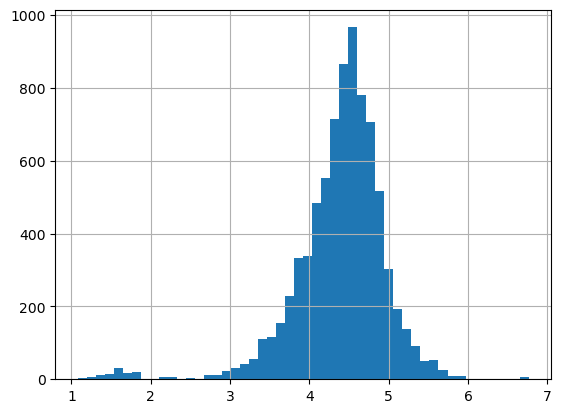

In [3]:
#Show distribution of target variable
y_data.hist(bins=50)
plt.show()

Based on the distribution of target data seems we have a mainly gaussian distribution centered around a a mean of ~4.5 but also a small outlier population between 1-2.  Try excluding values below 2.5 and greater than 6.5 from the X, Y data sets

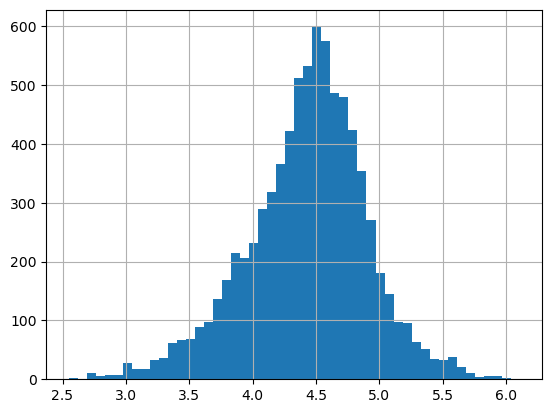

In [4]:
X_data, y_data = trim_outliers(X_data, y_data, min_max_values=(2.5, 6.5))

# Show distribution of target variable after trimming
y_data.hist(bins=50)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

#### Explore different estimators

- Random forest
- Ridge regression
- Lasso regression

In [6]:
# Grid search function
def search(estimator, params, X_train, y_train, scaler=None, save=True, verbose=3, plot=True):
    if scaler is None:
        grid = GridSearchCV(estimator, params, cv=5, n_jobs=-1, verbose=verbose)
    else:
        pipeline = Pipeline([("scaler", scaler), ("est", estimator)])
        new_params = {f'est__{k}': v for k, v in params.items()}
        grid = GridSearchCV(pipeline, new_params, cv=5, n_jobs=-1, verbose=verbose)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_score = grid.best_score_
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    title = f"{estimator.__class__.__name__}_{y_train.name}"

    if verbose > 0:
        print(f"Best score: {best_score}")
        print(f"Best params: {best_params}")

    if save:
        params_str = "_".join([f"{k}_{v}" for k, v in best_params.items()])
        filename = f"{title}_{params_str}.joblib"
        joblib.dump(model, filename=filename)

    if plot:
        y_pred = model.predict(X_test)
        plot_results(y_test, y_pred, title, r2, save=save) # type: ignore

    return model, best_score, best_params

#### Example Estimator - Random Forest Regressor

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.715 total time= 2.2min
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=0.714 total time= 2.2min
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.743 total time= 2.2min
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.718 total time= 2.2min
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.720 total time= 2.2min
Best score: 0.7221151416738772
Best params: {'max_depth': 10, 'n_estimators': 100}


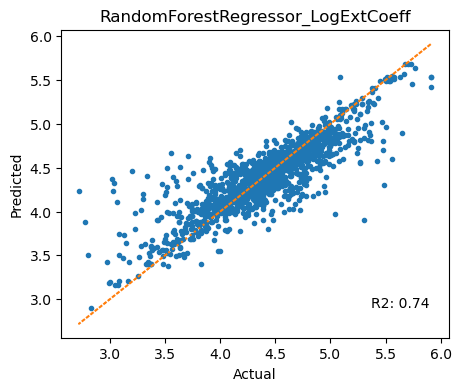

In [13]:
# This takes a long time to run so guarding against running it accidentally
model_path = "models/LogExtCoeff_no_outliers_dep_30_RF.joblib"
if os.path.exists(model_path):
    rf_estimator = joblib.load(model_path)
    y_pred = rf_estimator.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2 score: {r2:.2f}")
    params = rf_estimator.get_params()
    print(f"Params: {params}")
    naive_correrr = np.corrcoef(y_test, y_pred)[0, 1]
    print(f"Naive correlation error: {naive_correrr:.2f}")
    title = f"{rf_estimator.__class__.__name__}_{y_train.name}"
    plot_results(y_test, y_pred, title, r2, save=False) # type: ignore
else:
    rf_estimator, best_score, best_params = search(
        estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
        params = {
            "n_estimators": [100],# [100, 200],
            "max_depth": [10], #[None, 10, 20],
            # "max_features": [None, "sqrt"],
        },
        X_train=X_train,
        y_train=y_train,
        scaler=None,
        save=True,
        verbose=3,
        plot=True,
    )

Now compare to a random normal sample around based on the y_data mean and std

In [10]:
y_mean = y_train.mean()
y_std = y_train.std()
random_y_pred = np.random.normal(loc=y_mean, scale=y_std, size=y_test.shape[0])
r2 = r2_score(y_test, random_y_pred)
print(f"Random R2 score: {r2:.2f}")

Random R2 score: -1.06


#### Example Estimator - Linear Regressor - with regularization

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/en

[CV 5/5] END .....est__alpha=31.622776601683793;, score=0.579 total time=   1.3s
[CV 4/5] END .....est__alpha=31.622776601683793;, score=0.313 total time=   1.3s
[CV 3/5] END .....est__alpha=31.622776601683793;, score=0.623 total time=   1.4s
[CV 1/5] END .....est__alpha=31.622776601683793;, score=0.434 total time=   1.4s
[CV 2/5] END .....est__alpha=40.842386526745216;, score=0.564 total time=   1.4s
[CV 2/5] END .....est__alpha=31.622776601683793;, score=0.559 total time=   1.4s
[CV 1/5] END .....est__alpha=40.842386526745216;, score=0.475 total time=   1.4s
[CV 3/5] END .....est__alpha=40.842386526745216;, score=0.620 total time=   1.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 4/5] END .....est__alpha=40.842386526745216;, score=0.344 total time=   1.4s
[CV 1/5] END .....est__alpha=52.749970637026195;, score=0.507 total time=   1.4s
[CV 5/5] END .....est__alpha=40.842386526745216;, score=0.577 total time=   1.6s
[CV 3/5] END .....est__alpha=52.749970637026195;, score=0.617 total time=   1.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 4/5] END .....est__alpha=52.749970637026195;, score=0.369 total time=   1.6s
[CV 5/5] END .....est__alpha=52.749970637026195;, score=0.575 total time=   1.6s
[CV 2/5] END .....est__alpha=52.749970637026195;, score=0.567 total time=   1.7s
[CV 1/5] END ......est__alpha=68.12920690579611;, score=0.531 total time=   1.6s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 3/5] END ......est__alpha=68.12920690579611;, score=0.612 total time=   1.3s
[CV 2/5] END ......est__alpha=68.12920690579611;, score=0.569 total time=   1.4s
[CV 1/5] END ......est__alpha=87.99225435691069;, score=0.548 total time=   1.2s
[CV 3/5] END ......est__alpha=87.99225435691069;, score=0.607 total time=   1.2s
[CV 4/5] END ......est__alpha=68.12920690579611;, score=0.393 total time=   1.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 5/5] END ......est__alpha=68.12920690579611;, score=0.572 total time=   1.4s
[CV 4/5] END ......est__alpha=87.99225435691069;, score=0.414 total time=   1.2s
[CV 2/5] END ......est__alpha=87.99225435691069;, score=0.571 total time=   1.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/5] END .....est__alpha=113.64636663857242;, score=0.559 total time=   1.2s
[CV 5/5] END ......est__alpha=87.99225435691069;, score=0.570 total time=   1.2s
[CV 5/5] END .....est__alpha=113.64636663857242;, score=0.567 total time=   1.1s
[CV 4/5] END .....est__alpha=113.64636663857242;, score=0.433 total time=   1.1s
[CV 2/5] END .....est__alpha=113.64636663857242;, score=0.571 total time=   1.2s
[CV 3/5] END .....est__alpha=113.64636663857242;, score=0.601 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/5] END ......est__alpha=146.7799267622069;, score=0.564 total time=   1.2s
[CV 2/5] END ......est__alpha=146.7799267622069;, score=0.572 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 3/5] END ......est__alpha=146.7799267622069;, score=0.593 total time=   1.2s
[CV 4/5] END ......est__alpha=146.7799267622069;, score=0.451 total time=   1.2s
[CV 5/5] END ......est__alpha=146.7799267622069;, score=0.565 total time=   1.2s
[CV 2/5] END .....est__alpha=189.57356524063755;, score=0.571 total time=   1.2s
[CV 1/5] END .....est__alpha=189.57356524063755;, score=0.566 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 3/5] END .....est__alpha=189.57356524063755;, score=0.586 total time=   1.2s
[CV 4/5] END .....est__alpha=189.57356524063755;, score=0.466 total time=   1.2s
[CV 5/5] END .....est__alpha=189.57356524063755;, score=0.562 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 2/5] END .....est__alpha=244.84367468222268;, score=0.570 total time=   1.1s
[CV 1/5] END .....est__alpha=244.84367468222268;, score=0.564 total time=   1.2s
[CV 3/5] END .....est__alpha=244.84367468222268;, score=0.577 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 1/5] END .....est__alpha=316.22776601683796;, score=0.560 total time=   1.2s
[CV 4/5] END .....est__alpha=244.84367468222268;, score=0.478 total time=   1.2s
[CV 5/5] END .....est__alpha=244.84367468222268;, score=0.558 total time=   1.3s
[CV 2/5] END .....est__alpha=316.22776601683796;, score=0.568 total time=   1.2s
[CV 3/5] END .....est__alpha=316.22776601683796;, score=0.568 total time=   1.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV 5/5] END .....est__alpha=316.22776601683796;, score=0.555 total time=   0.9s
[CV 4/5] END .....est__alpha=316.22776601683796;, score=0.488 total time=   0.9s
Best score: 0.5499567806186558
Best params: {'est__alpha': 189.57356524063755}


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


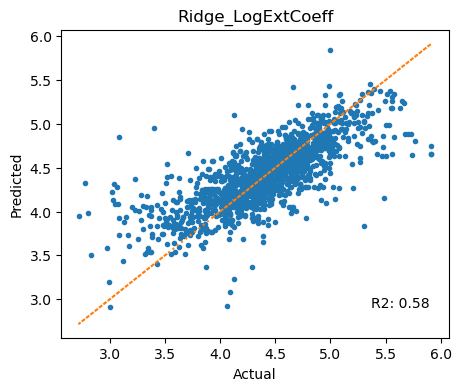

In [11]:
# Perform grid search
ridge, best_score, best_params = search(
    estimator=Ridge(random_state=42),
    params={
        "alpha": np.logspace(1.5, 2.5, 10),
    },
    X_train=X_train,
    y_train=y_train,
    scaler=StandardScaler(),
    save=False,
    verbose=3,
    plot=True,
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e+02, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+02, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 3/5] END .est__alpha=0.00012742749857031334;, score=0.555 total time=   5.4s
[CV 2/5] END .est__alpha=0.00012742749857031334;, score=0.553 total time=   5.5s
[CV 1/5] END .est__alpha=0.00012742749857031334;, score=0.570 total time=   5.5s
[CV 5/5] END .................est__alpha=0.0001;, score=0.133 total time=   5.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e+02, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+02, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 1/5] END .................est__alpha=0.0001;, score=0.564 total time=   5.6s
[CV 4/5] END .................est__alpha=0.0001;, score=0.474 total time=   5.6s
[CV 3/5] END .................est__alpha=0.0001;, score=0.460 total time=   5.6s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+02, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .................est__alpha=0.0001;, score=0.537 total time=   5.8s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+02, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+02, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 4/5] END .est__alpha=0.00012742749857031334;, score=0.478 total time=   5.5s
[CV 1/5] END ..est__alpha=0.0001623776739188721;, score=0.567 total time=   5.3s
[CV 2/5] END ..est__alpha=0.0001623776739188721;, score=0.560 total time=   5.4s
[CV 3/5] END ..est__alpha=0.0001623776739188721;, score=0.587 total time=   5.3s
[CV 4/5] END ..est__alpha=0.0001623776739188721;, score=0.486 total time=   5.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.683e+01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e+02, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 1/5] END .est__alpha=0.00020691380811147902;, score=0.567 total time=   5.2s
[CV 5/5] END .est__alpha=0.00012742749857031334;, score=0.220 total time=   5.6s
[CV 5/5] END ..est__alpha=0.0001623776739188721;, score=0.284 total time=   5.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.901e+01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.606e+01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 3/5] END .est__alpha=0.00020691380811147902;, score=0.605 total time=   5.3s
[CV 3/5] END .est__alpha=0.00026366508987303583;, score=0.597 total time=   5.1s
[CV 4/5] END .est__alpha=0.00020691380811147902;, score=0.497 total time=   5.3s
[CV 2/5] END .est__alpha=0.00026366508987303583;, score=0.577 total time=   5.2s
[CV 1/5] END .est__alpha=0.00026366508987303583;, score=0.568 total time=   5.3s
[CV 2/5] END .est__alpha=0.00020691380811147902;, score=0.569 total time=   5.4s
[CV 4/5] END .est__alpha=0.00026366508987303583;, score=0.531 total time=   5.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+02, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .est__alpha=0.00020691380811147902;, score=0.349 total time=   5.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.114e+01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.657e+01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 1/5] END .est__alpha=0.00042813323987193956;, score=0.583 total time=   4.9s
[CV 5/5] END ..est__alpha=0.0003359818286283781;, score=0.308 total time=   5.0s
[CV 3/5] END ..est__alpha=0.0003359818286283781;, score=0.622 total time=   5.0s
[CV 4/5] END ..est__alpha=0.0003359818286283781;, score=0.553 total time=   5.0s
[CV 1/5] END ..est__alpha=0.0003359818286283781;, score=0.573 total time=   5.1s
[CV 2/5] END ..est__alpha=0.0003359818286283781;, score=0.582 total time=   5.1s
[CV 2/5] END .est__alpha=0.00042813323987193956;, score=0.588 total time=   4.9s
[CV 5/5] END .est__alpha=0.00026366508987303583;, score=0.324 total time=   5.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.884e+01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.880e+01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 2/5] END ...est__alpha=0.000545559478116852;, score=0.584 total time=   4.8s
[CV 4/5] END ...est__alpha=0.000545559478116852;, score=0.552 total time=   4.8s
[CV 1/5] END ...est__alpha=0.000545559478116852;, score=0.586 total time=   4.9s
[CV 3/5] END ...est__alpha=0.000545559478116852;, score=0.632 total time=   4.8s
[CV 3/5] END .est__alpha=0.00042813323987193956;, score=0.634 total time=   4.9s
[CV 5/5] END ...est__alpha=0.000545559478116852;, score=0.403 total time=   4.8s
[CV 5/5] END .est__alpha=0.00042813323987193956;, score=0.363 total time=   4.9s
[CV 4/5] END .est__alpha=0.00042813323987193956;, score=0.553 total time=   5.0s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.833e+01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.140e+01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 5/5] END ..est__alpha=0.0006951927961775605;, score=0.465 total time=   4.6s
[CV 1/5] END ..est__alpha=0.0006951927961775605;, score=0.586 total time=   4.7s
[CV 2/5] END ..est__alpha=0.0008858667904100823;, score=0.574 total time=   4.6s
[CV 2/5] END ..est__alpha=0.0006951927961775605;, score=0.579 total time=   4.7s
[CV 3/5] END ..est__alpha=0.0008858667904100823;, score=0.626 total time=   4.6s
[CV 4/5] END ..est__alpha=0.0006951927961775605;, score=0.560 total time=   4.7s
[CV 1/5] END ..est__alpha=0.0008858667904100823;, score=0.581 total time=   4.6s
[CV 3/5] END ..est__alpha=0.0006951927961775605;, score=0.632 total time=   4.7s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.568e+00, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.461e+00, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 3/5] END ..est__alpha=0.0011288378916846883;, score=0.619 total time=   4.6s
[CV 5/5] END ..est__alpha=0.0011288378916846883;, score=0.498 total time=   4.5s
[CV 2/5] END ..est__alpha=0.0011288378916846883;, score=0.565 total time=   4.6s
[CV 5/5] END ..est__alpha=0.0008858667904100823;, score=0.479 total time=   4.7s
[CV 4/5] END ..est__alpha=0.0008858667904100823;, score=0.568 total time=   4.8s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+00, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+00, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..est__alpha=0.0011288378916846883;, score=0.568 total time=   4.8s
[CV 1/5] END ..est__alpha=0.0014384498882876629;, score=0.569 total time=   4.9s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.426e+00, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..est__alpha=0.0011288378916846883;, score=0.578 total time=   5.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e+00, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.967e+00, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 2/5] END ..est__alpha=0.0014384498882876629;, score=0.552 total time=   4.4s
[CV 5/5] END ..est__alpha=0.0014384498882876629;, score=0.526 total time=   4.4s
[CV 3/5] END ..est__alpha=0.0014384498882876629;, score=0.613 total time=   4.6s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.778e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.289e-01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..est__alpha=0.0018329807108324356;, score=0.539 total time=   4.5s
[CV 3/5] END ..est__alpha=0.0018329807108324356;, score=0.606 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..est__alpha=0.0018329807108324356;, score=0.556 total time=   4.6s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+00, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..est__alpha=0.0014384498882876629;, score=0.564 total time=   5.6s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e-01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..est__alpha=0.0018329807108324356;, score=0.554 total time=   5.7s
[CV 1/5] END ...est__alpha=0.002335721469090121;, score=0.542 total time=   4.0s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.424e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 2/5] END ...est__alpha=0.002335721469090121;, score=0.532 total time=   4.5s
[CV 5/5] END ..est__alpha=0.0018329807108324356;, score=0.534 total time=   4.7s
[CV 4/5] END ...est__alpha=0.002335721469090121;, score=0.547 total time=   4.4s
[CV 3/5] END ...est__alpha=0.002335721469090121;, score=0.600 total time=   4.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ...est__alpha=0.002335721469090121;, score=0.532 total time=   4.4s
[CV 1/5] END ...est__alpha=0.002976351441631319;, score=0.529 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...est__alpha=0.002976351441631319;, score=0.524 total time=   4.4s
[CV 4/5] END ...est__alpha=0.002976351441631319;, score=0.534 total time=   2.8s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e-01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...est__alpha=0.002976351441631319;, score=0.592 total time=   4.5s
[CV 4/5] END ....est__alpha=0.00379269019073225;, score=0.522 total time=   3.0s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

[CV 2/5] END ....est__alpha=0.00379269019073225;, score=0.514 total time=   4.3s
[CV 5/5] END ...est__alpha=0.002976351441631319;, score=0.523 total time=   4.4s
[CV 1/5] END ....est__alpha=0.00379269019073225;, score=0.513 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e-01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ....est__alpha=0.00379269019073225;, score=0.581 total time=   4.5s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ....est__alpha=0.00379269019073225;, score=0.514 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ...est__alpha=0.004832930238571752;, score=0.494 total time=   4.4s
[CV 4/5] END ...est__alpha=0.004832930238571752;, score=0.508 total time=   2.9s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...est__alpha=0.004832930238571752;, score=0.499 total time=   4.3s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e-01, tolerance: 1.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...est__alpha=0.004832930238571752;, score=0.567 total time=   4.5s
[CV 5/5] END ...est__alpha=0.004832930238571752;, score=0.498 total time=   4.2s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-01, tolerance: 1.738e-01
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ....est__alpha=0.00615848211066026;, score=0.475 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.806e-01, tolerance: 1.742e-01
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ....est__alpha=0.00615848211066026;, score=0.484 total time=   4.3s
[CV 3/5] END ....est__alpha=0.00615848211066026;, score=0.550 total time=   3.9s
[CV 3/5] END ...est__alpha=0.007847599703514606;, score=0.532 total time=   2.7s
[CV 4/5] END ....est__alpha=0.00615848211066026;, score=0.494 total time=   4.4s


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.714e-01
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ....est__alpha=0.00615848211066026;, score=0.486 total time=   4.3s
[CV 1/5] END ...................est__alpha=0.01;, score=0.439 total time=   2.2s
[CV 2/5] END ...est__alpha=0.007847599703514606;, score=0.468 total time=   3.3s
[CV 1/5] END ...est__alpha=0.007847599703514606;, score=0.458 total time=   3.7s
[CV 4/5] END ...est__alpha=0.007847599703514606;, score=0.476 total time=   4.0s
[CV 2/5] END ...................est__alpha=0.01;, score=0.453 total time=   1.6s
[CV 3/5] END ...................est__alpha=0.01;, score=0.513 total time=   1.5s
[CV 5/5] END ...est__alpha=0.007847599703514606;, score=0.472 total time=   3.6s
[CV 4/5] END ...................est__alpha=0.01;, score=0.460 total time=   2.4s
[CV 5/5] END ...................est__alpha=0.01;, score=0.459 total time=   2.4s
Best score: 0.565568913830445
Best params: {'est__alpha': 0.0008858667904100823}


/Users/thomasfuller/ML/spectrum/envs/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.992e+00, tolerance: 2.154e-01
  model = cd_fast.enet_coordinate_descent(


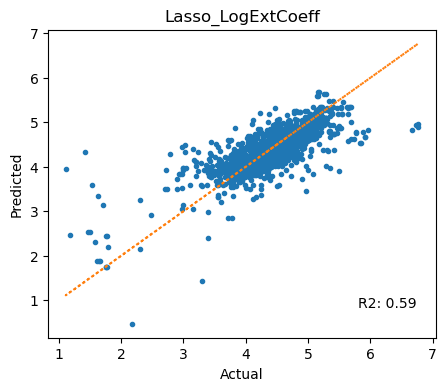

In [9]:
# Lasso grid search
model, best_score, best_params = search(
    estimator=Lasso(random_state=42),
    params={
        "alpha": np.logspace(-4, -2, 20),
    },
    X_train=X_train,
    y_train=y_train,
    scaler=StandardScaler(),
    save=False,
    verbose=3,
)

Even with regularization the model fails to converge well and results in significantly worse performance than the Random Forest.